In [1]:
# パッケージ
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, SimpleRNN, GRU
from keras import optimizers
from keras.callbacks import EarlyStopping

2023-06-13 23:50:37.581974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 23:50:38.707937: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
target_data = pd.read_csv("./target/target_USDJPY.csv")
model = tf.keras.models.load_model("/home/etherpoc/workspace/trading-fx/src/models/model60_120_20230606_154811.h5")
#----OPTIONS----
unitsRNN  = 60
maxlen = 120

2023-06-13 23:50:40.054530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 23:50:40.401364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 23:50:40.401432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 23:50:40.403833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-13 23:50:40.403900: I tensorflow/compile

In [3]:
'''
1. データの準備
'''

x = [target_data["deviation_rate"][i:i+maxlen].values for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen)]
# x = []
# for i in range(59, len(target_data["deviation_rate"].values[:])-maxlen):
#     d = []
#     h = []
#     l = []
#     for j in range(maxlen):
#         d.append(target_data["deviation_rate"].values[i+j])
#         h.append(target_data["high"].values[i+j]/target_data["open"].values[i+j])
#         l.append(target_data["low"].values[i+j]/target_data["open"].values[i+j])
#     ilist = pd.DataFrame(data={
#         "deviation_rate": d,
#         "high": h,
#         "low": l
#     })
#     x.append(ilist)
t = [ target_data["rise_rate"][i+maxlen-1] for i in range(59, len(target_data["rise_rate"].values[:])-maxlen)]

x = np.array(x).reshape(-1, maxlen, 1)
t = np.array(t).reshape(-1, 1)
print(x.shape, t.shape)

x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, shuffle=False)

(51546, 120, 1) (51546, 1)


2023-06-13 23:50:44.940978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 23:50:44.943141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 23:50:44.944527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1611/1611 [==============================] - 14s 6ms/step


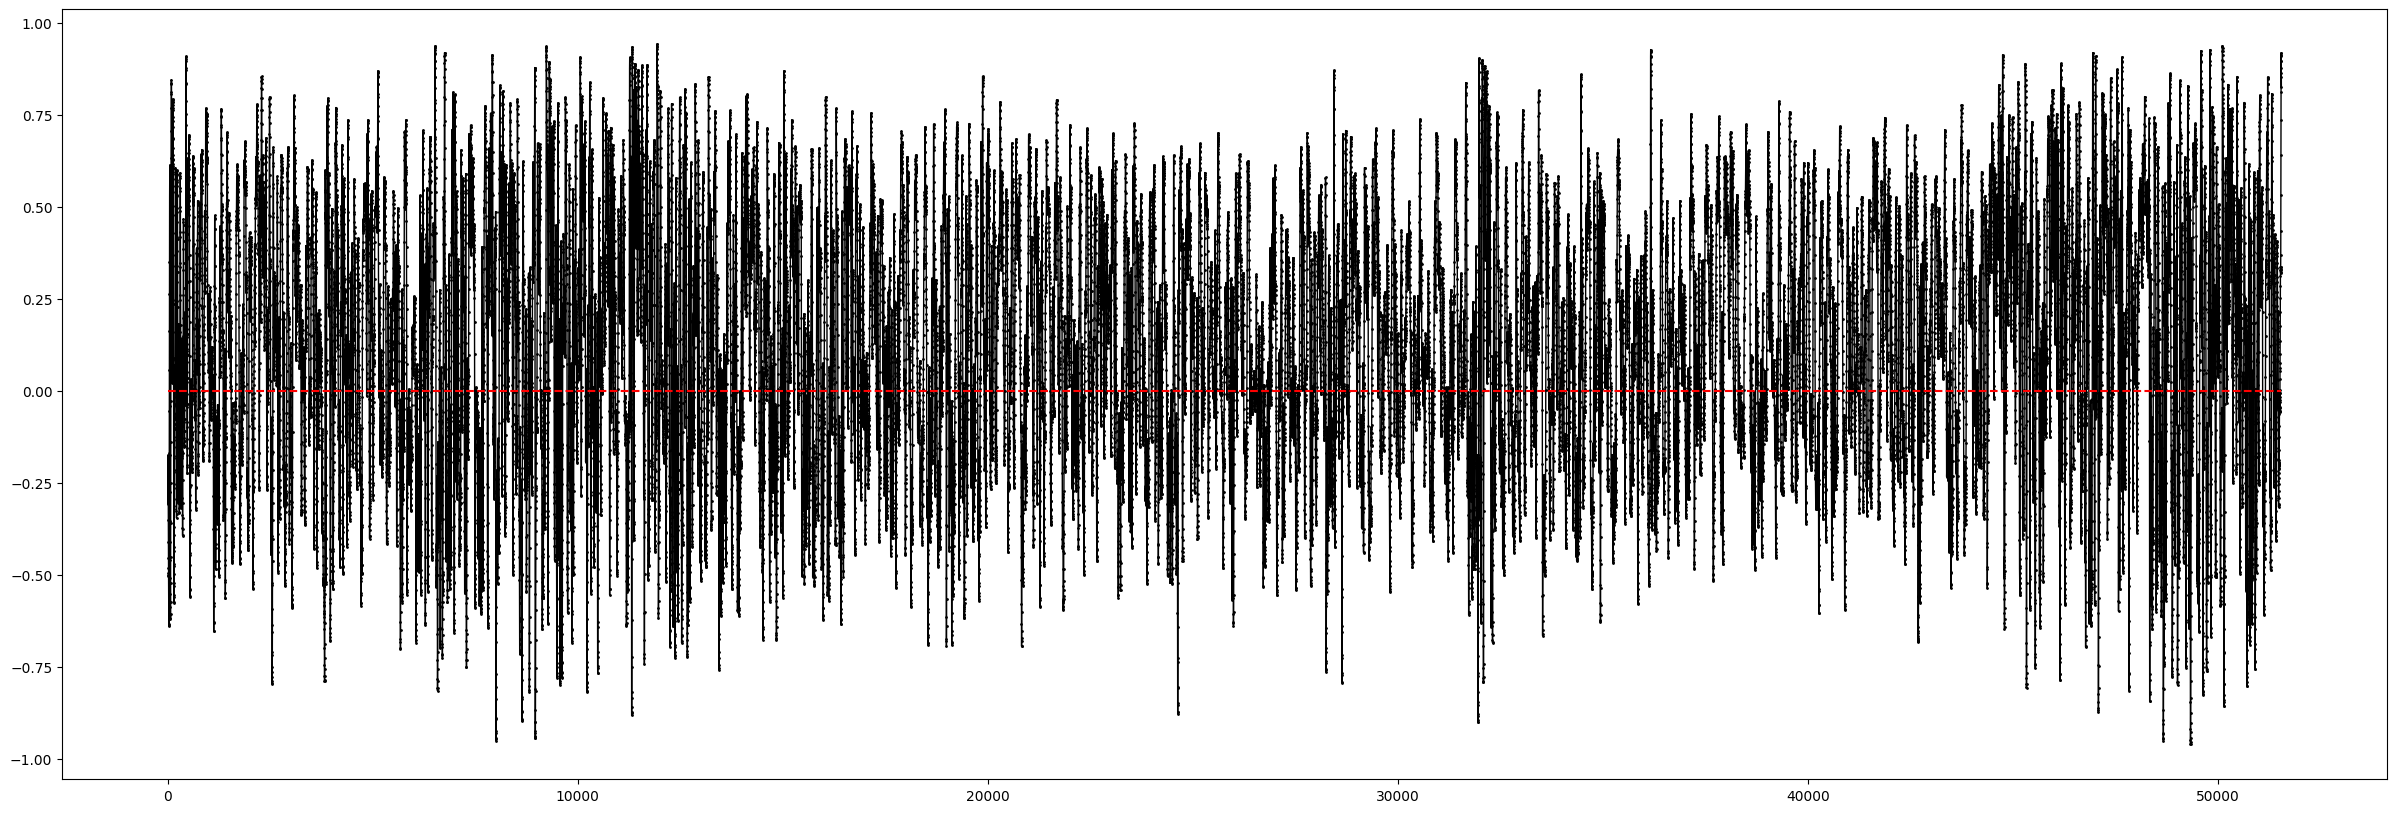

In [4]:


'''
4. モデルの評価
'''
indata = t
predicted = []

preds = model.predict(x)
for i in range(len(preds)):
    predicted.append(preds[i])

# 予測値を可視化
fig = plt.figure(figsize=(30, 10))
plot_length = len(predicted)
plt.plot(range(plot_length), predicted[:plot_length],
        color='black', linewidth=1,
        marker='o', markersize=1, markerfacecolor='black',
        markeredgecolor='black')
plt.plot([0, plot_length],[0, 0], "red", linestyle='dashed')
plt.show()

In [5]:
len(predicted)

51546

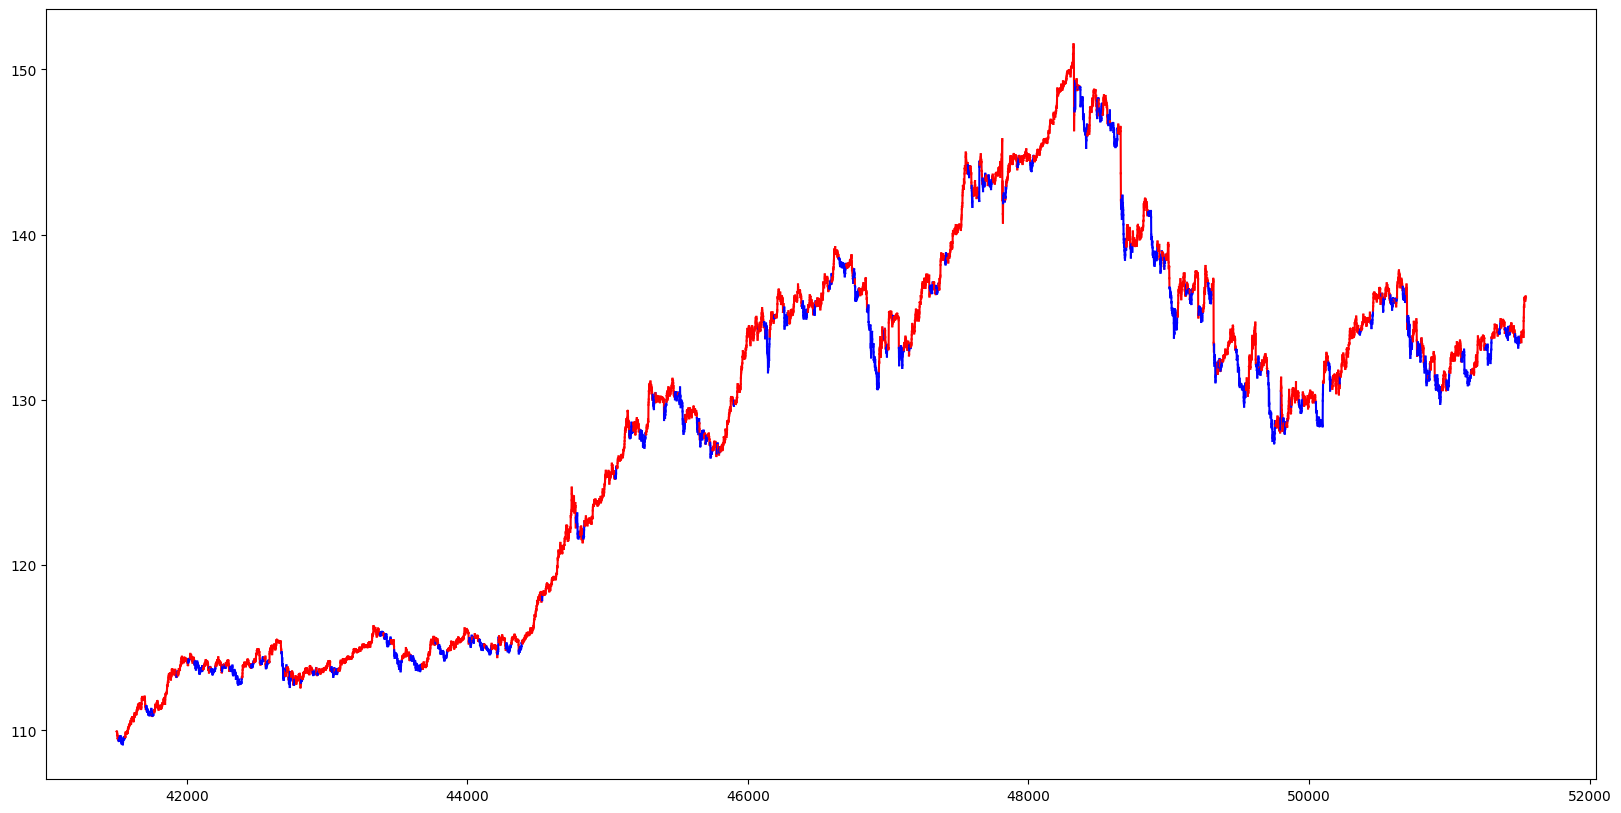

In [6]:
# 実データに反映し描画
chart = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
fig = plt.figure(figsize=(20,10))
plot_length = len(chart)
for i in range(41500,plot_length-1):
    plt.plot(range(plot_length+1)[i:i+2], chart[i:i+2], color= 'red' if predicted[i] > 0 else 'blue')
plt.show()

In [33]:

import csv
import os

reserch_file_path = "/home/etherpoc/workspace/trading-fx/src/ML/simulation_graph/model60_120_20230606_154811/data.csv"
header = ['tk_pips', 'ls_pips', "gain_rate"]
if not os.path.exists(reserch_file_path):
    with open(reserch_file_path, "w") as f:
        writer = csv.writer(f)
        writer.writerow(header)

chart       = [target_data["close"][i+maxlen-1] for i in range(59, len(target_data["close"].values[:])-maxlen)]
chart_high  = [target_data["high"][i+maxlen-1]  for i in range(59, len(target_data["high"].values[:])-maxlen)]
chart_low   = [target_data["low"][i+maxlen-1]   for i in range(59, len(target_data["low"].values[:])-maxlen)]

# Trading Simulation
for ls_pips in np.arange(0, 1.0, 0.05):
    #---OPTIONS---
    first    = 100000.0     # Initial Amount
    per      = 10           # One Time Investment Amount(%)
    per_lot  = 100000       # Number of Currencies per lot
    leverage = 100          # Leverage (int)
    tk_pips  = 1.08         # Take Profit (pips)
    ls_pips  = ls_pips          # Loss Cut (pips)
    position = None         # Position Status ("Buy","Sell",None)
    position_data   = None  # Info about now position [index, trading price, lots]
    recent_position = None  # Most Recent Position [index, trading price, lots]
    result_history = []     # Record Simulation Results
    result = {
        "win"   : 0,        # Win Count
        "lose"  : 0,        # Lose Count
        "tk"    : 0,        # Take Profit Count
        "ls"    : 0,        # Loss Cut Count
        "total" : first,    # Final Amount
        "gain_rate": 0,     # Final Gain Rate
    }
    #------------

    for i in range(0, len(predicted)):
        # Record
        result_history.append(result["total"])
        # Having Position
        if position in ["Buy", "Sell"]:
            # Loss Cut
            if (position == "Buy" and position_data[1] - chart_low[i] > ls_pips)\
                or (position == "Sell" and chart_high[i] - position_data[1] > ls_pips):
                result["total"] -= ls_pips * position_data[2] * per_lot
                flag_traded = True
                position = None
                result["lose"] += 1
                result["ls"] += 1
                continue
                
            # Take Profit
            elif (position == "Buy" and chart_high[i] - position_data[1] > tk_pips)\
                or (position == "Sell" and position_data[1] - chart_low[i] > tk_pips):
                result["total"] += tk_pips * position_data[2] * per_lot
                flag_traded = True
                position = None
                result["win"] += 1
                result["tk"] += 1
                continue
                
        
        profit = 0
        flag_create_position = False
        if position == None:
            if predicted[i] > 0:
                position = "Buy"
            else:
                position = "Sell"
            flag_create_position = True
                
        elif position == "Buy" and predicted[i] < 0:
            # Close Position
            profit = (chart[i] - position_data[1]) * position_data[2] * per_lot
            # Change Position
            position = "Sell"
            flag_create_position = True
                
        elif position == "Sell" and predicted[i] > 0:
            # Close Position
            profit = (position_data[1] - chart[i]) * position_data[2] * per_lot
            # Change Position
            position = "Buy"
            flag_create_position = True
            
        if profit != 0:
            result["total"] += profit
            if profit > 0:
                result["win"] += 1
            else:
                result["lose"] += 1
                
        if flag_create_position:
            lots = (result["total"] * (per /100) * leverage / chart[i]) / per_lot
            position_data = [i, chart[i], lots]
        

    result["gain_rate"] = result["total"]/first
    print(f"WIN  : {result['win']}, Take Profit : {result['tk']}")
    print(f"LOSE : {result['lose']}, Loss Cut    : {result['ls']}")
    print(f"Final Amount : {result['total']}")
    print(f"Final Gain Rate : {result['gain_rate']}")
    # シミュレーションの推移
    fig = plt.figure(figsize=(20,10))
    plt.plot(result_history)
    # plt.show()
    plt.savefig(f"./simulation_graph/tk_pips{tk_pips}ls_pips{ls_pips}.png")
    plt.clf()
    del fig
            
    with open(reserch_file_path, "a") as f:
        writer = csv.writer(f)
        writer.writerow([tk_pips, ls_pips, result['gain_rate']])

WIN  : 111, Take Profit : 72
LOSE : 23086, Loss Cut    : 23086
Final Amount : 102880368.72151268
Final Gain Rate : 1028.8036872151267
WIN  : 921, Take Profit : 347
LOSE : 8123, Loss Cut    : 8046
Final Amount : 3963040.8640404916
Final Gain Rate : 39.630408640404916
WIN  : 1088, Take Profit : 418
LOSE : 5135, Loss Cut    : 4950
Final Amount : 2280331.7175752204
Final Gain Rate : 22.803317175752206
WIN  : 1101, Take Profit : 435
LOSE : 3711, Loss Cut    : 3397
Final Amount : 1548241.7360152386
Final Gain Rate : 15.482417360152386
WIN  : 1068, Take Profit : 436
LOSE : 2945, Loss Cut    : 2539
Final Amount : 425646.8623995494
Final Gain Rate : 4.256468623995494
WIN  : 1043, Take Profit : 433
LOSE : 2415, Loss Cut    : 1911
Final Amount : 1017202.9150326875
Final Gain Rate : 10.172029150326875
WIN  : 1002, Take Profit : 423
LOSE : 2086, Loss Cut    : 1520
Final Amount : 811638.8575394406
Final Gain Rate : 8.116388575394407
WIN  : 979, Take Profit : 426
LOSE : 1852, Loss Cut    : 1209
Final

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>